In [ ]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

In [ ]:
# load dataset---> Cora
from torch_geometric.datasets import Planetoid

dataset=Planetoid(root='/tmp/Cora', name='Cora')
# dataset=Planetoid(root='/tmp/Citeseer', name='Citeseer')
# dataset=Planetoid(root='/tmp/Pubmed', name='Pubmed')
data=dataset[0]


In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [ ]:
print(data)
print('==========================statistics about the graph===================================')


print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [ ]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
# ---------------------------- visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

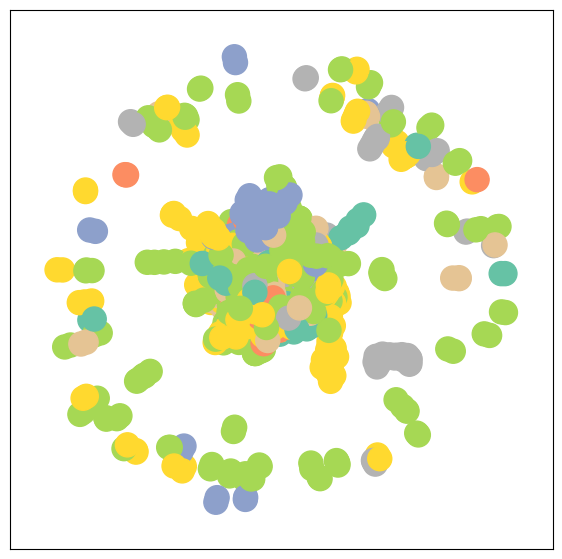

In [ ]:
# show graph G  into 2-dim
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [ ]:
# K=3
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, 128)
        self.classifier = Linear(128, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()


        out = self.classifier(h)

        return out, h

In [ ]:
# create  model

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)


Embedding shape: [2708, 128]


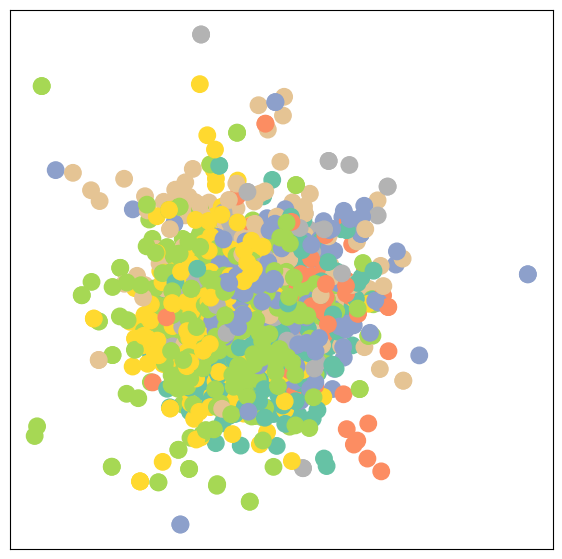

In [ ]:


_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

In [ ]:
out, h = model(data.x, data.edge_index)

In [ ]:
out[data.train_mask].shape

torch.Size([140, 7])

In [ ]:
outputs = torch.nn.functional.log_softmax(out[data.train_mask], dim=1)

In [ ]:
edge_index = data.edge_index

# --------------------------- adjacency matrix
num_nodes = data.num_nodes
adjacency_matrix = torch.zeros((num_nodes, num_nodes))
adjacency_matrix[edge_index[0], edge_index[1]] = 1
adjacency_matrix[edge_index[1], edge_index[0]] = 1

print(adjacency_matrix)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [ ]:
A=adjacency_matrix
s=h

In [ ]:
import random
#-----------calcuate similarity between two embedding vectors
def cal_simi(s1,s2):
  dot_product=torch.dot(s1,s2)
  norm_product=torch.norm(s1)*torch.norm(s2)
  simi=torch.exp(dot_product / norm_product)
  return simi

#---------------------- calculate U+ -----------------
def Uplus(A,s):
  Uplus=[]
  adj=[]
  random_adj=[]
  for i in range(len(A)):
      U=0
      adj=[]
      random_adj=[]
      for j in A[i].nonzero():
        adj.append(j)
      if len(adj)>= 5:
        random_adj.append(random.sample(adj,5))
        random_adj=random_adj[0]
      else:
        random_adj=adj
      if len(random_adj)>0:
        for j in random_adj:
          # print(i,j)
          U+=A[i][j]*cal_simi(s[i],s[j][0])
      Uplus.append(U)
  return Uplus



In [ ]:
Ak=torch.mm(A,A)

In [ ]:
Abar=1-Ak
Abar[0]

tensor([-2.,  1.,  1.,  ...,  1.,  1.,  1.])

In [ ]:

#------------ calculate U- ---------------------
def Umin(A,s):
  U=0
  Umin=[]
  n_adj=[]
  random_adj=[]
  for i in range(len(A)):
    U=0
    for j in torch.nonzero(A[i] == 0):
        n_adj.append(j)
    for j in torch.nonzero(Ak[i] == 0):
      if j !=i:
        n_adj.append(j)
    if len(n_adj)>= 10:
        random_adj=random.sample(n_adj,10)
        random_adj=random_adj[0]
    else:
        random_adj=n_adj
        random_adj=random_adj[0]
    if len(random_adj)>0:
        for j in random_adj:
          # print(i,j)
          if s[j].shape ==torch.Size([1, 2]):
            U+=Abar[i][j]*cal_simi(s[i],s[j][0])
          else:
            U+=Abar[i][j]*cal_simi(s[i],s[j])
    Umin.append(U)
  return Umin



In [ ]:
import torch
import torch.nn as nn

class MyCustomLoss(nn.Module):
    def __init__(self):
        super(MyCustomLoss, self).__init__()

    def forward(self,h, predictions, labels):

        uplus=Uplus(A,h)
        umin=Umin(A,h)
        uplus=torch.tensor(uplus)
        umin=torch.tensor(umin)

        loss=torch.mean(-1*(torch.log(uplus)-torch.log(uplus+umin)))

        criterion1 = torch.nn.CrossEntropyLoss()
        loss2 = criterion1(predictions, labels)



        return (loss+loss2)/2
criterion = MyCustomLoss()

In [ ]:
# define train function


optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss1 = criterion(h,out[data.train_mask], data.y[data.train_mask])

    loss1.backward()
    optimizer.step()

    accuracy = {}

    predicted_classes = torch.argmax(out[data.train_mask], axis=1)
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss1, h, accuracy

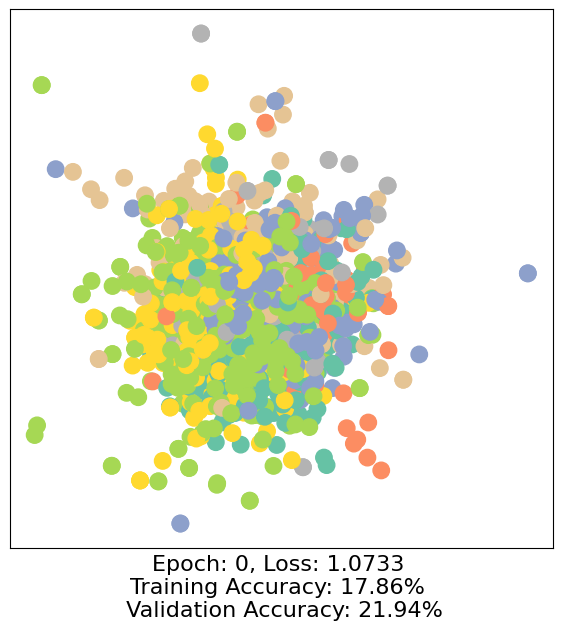

epoch= 0
loss= tensor(1.0733, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(0.1786), 'val': tensor(0.2194)}


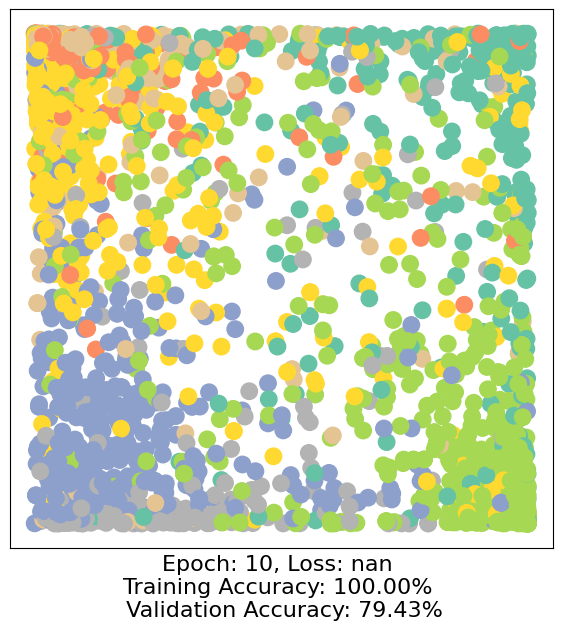

epoch= 10
loss= tensor(nan, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7943)}


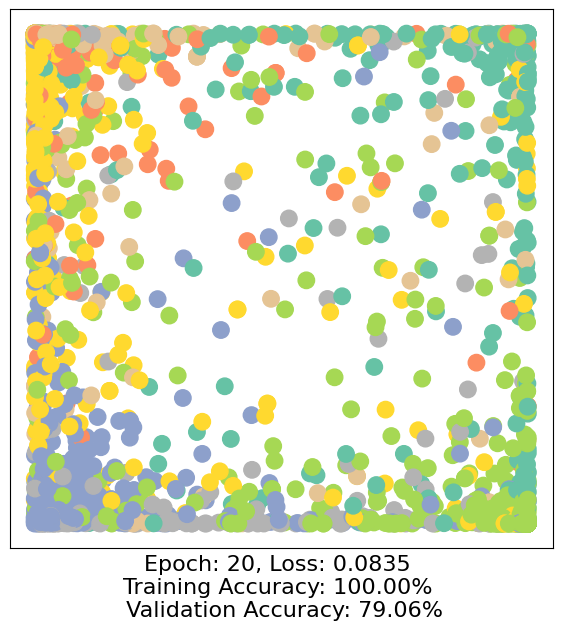

epoch= 20
loss= tensor(0.0835, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7906)}


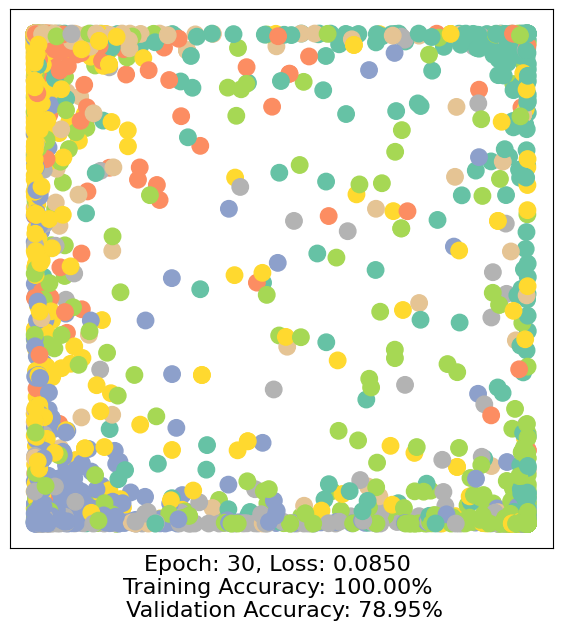

epoch= 30
loss= tensor(0.0850, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7895)}


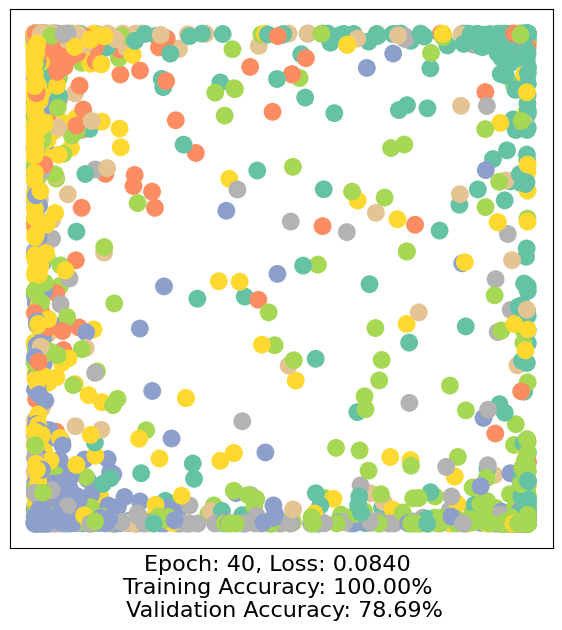

epoch= 40
loss= tensor(0.0840, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7869)}


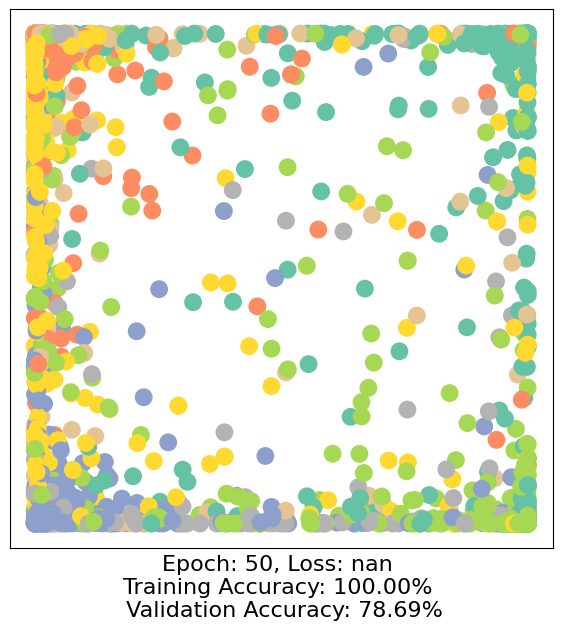

epoch= 50
loss= tensor(nan, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7869)}


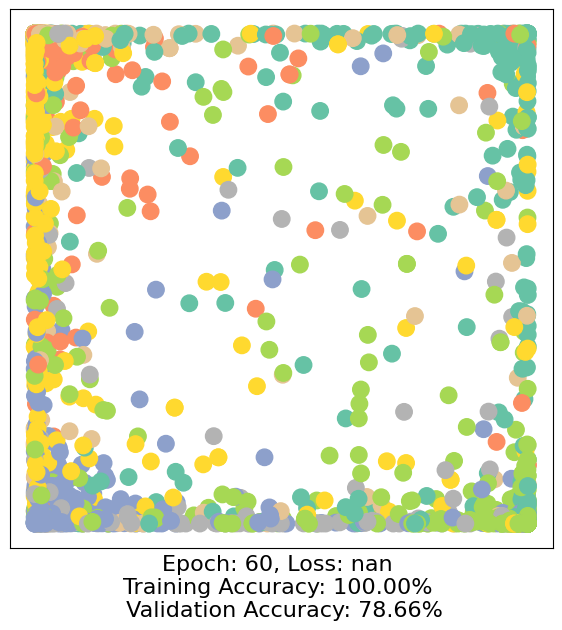

epoch= 60
loss= tensor(nan, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7866)}


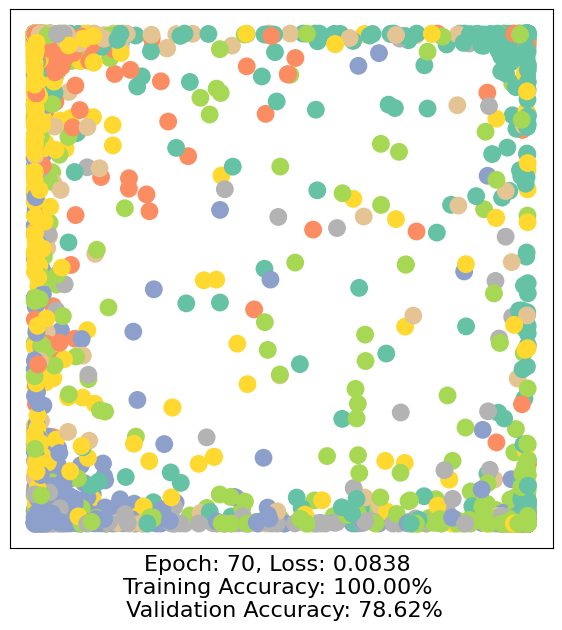

epoch= 70
loss= tensor(0.0838, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7862)}


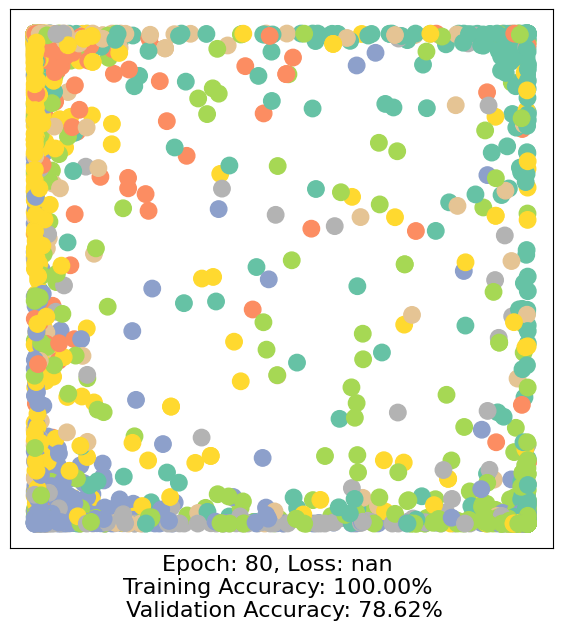

epoch= 80
loss= tensor(nan, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7862)}


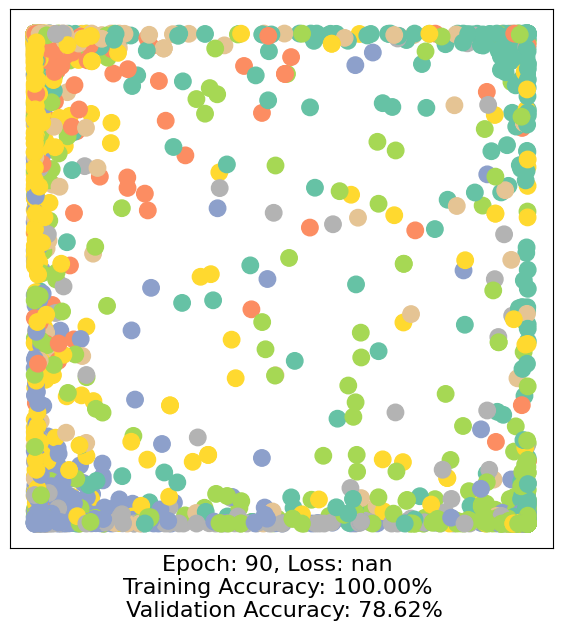

epoch= 90
loss= tensor(nan, grad_fn=<DivBackward0>)
accuracy= {'train': tensor(1.), 'val': tensor(0.7862)}


In [ ]:
import time
for epoch in range(100):
    loss, h, accuracy = train(data)
    # ------visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        print("epoch=",epoch)
        print("loss=",loss)
        print("accuracy=",accuracy)
        time.sleep(0.3)